CELL TWO BELOW:

Data preprocessing

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
import sys

dataset_dir = "ravdess_dataset"
#Below code grabs all the .wav files to be grouped
wav_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))


#extract the file names so as to group them by attributes
data = []
for file in wav_files:
    file_name = os.path.basename(file)
    parts = file_name.split('-')
    modality = parts[0]
    vocal_channel = parts[1]
    emotion = parts[2]
    intensity = parts[3]
    actor = parts[6].split('.')[0]
    data.append([file_name, modality, vocal_channel, emotion, intensity, actor])

#Setup our dataframe
df = pd.DataFrame(data, columns=["filename", "modality", "vocal_channel", "emotion", "intensity", "actor"])
#Audio only files (refer to dataset description)
df_audio_only = df[df['modality'] == '03']
#Make sure to separate... Only want to be using speech files
df_speech = df_audio_only[df_audio_only['vocal_channel'] == '01']
df_song = df_audio_only[df_audio_only['vocal_channel'] == '02']

#Mapping emotionns to labels
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
df_speech['emotion'] = df_speech['emotion'].map(emotion_map)
df_song['emotion'] = df_song['emotion'].map(emotion_map)

#Printing out to make sure distribution looks alright
print("Speech emotion counts:\n", df_speech['emotion'].value_counts())
print("\nSong emotion counts:\n", df_song['emotion'].value_counts())


Speech emotion counts:
 emotion
disgust      384
sad          384
happy        384
fearful      384
angry        384
surprised    384
calm         384
neutral      192
Name: count, dtype: int64

Song emotion counts:
 Series([], Name: count, dtype: int64)


CELL THREE BELOW:


Train and test splitting below. Also prints out demographics and characteristics of each split, so as to make sure proportions of each emotion, each gender, and each intensity level is approximately even across splits (save for the value of "neutral", as there are two intensity levels for each emotion, except netural. )

In [ ]:
from sklearn.model_selection import train_test_split

# below , labels are created for emotion, intensity, and gender
df_speech['intensity'] = df_speech['intensity']
#Map gendered info
df_speech['gender'] = df_speech['actor'].apply(lambda x: 'male' if int(x) % 2 != 0 else 'female')

# Perform stratified train/test split to maintain emotion, intensity, and gender balance
X_train_df, X_temp_df, y_train, y_temp = train_test_split(
    df_speech, df_speech['emotion'],
    test_size=0.3, stratify=df_speech[['emotion', 'intensity', 'gender']], random_state=42
)

#Split for test and train and val
X_val_df, X_test_df, y_val, y_test = train_test_split(
    X_temp_df, y_temp,
    test_size=0.5, stratify=X_temp_df[['emotion', 'intensity', 'gender']], random_state=42
)

#printout info on splits
print(f"Training set size: {len(X_train_df)}")
print(f"Validation set size: {len(X_val_df)}")
print(f"Test set size: {len(X_test_df)}")

# bbelow is a Function to print emotion, intensity, and gender distribution
def print_split_stats(df_split, split_name):
    print(f"\n{split_name} Stats:")
    print("Emotion distribution:")
    print(df_split['emotion'].value_counts())
    print("\nIntensity distribution:")
    print(df_split['intensity'].value_counts())
    print("\nGender distribution:")
    print(df_split['gender'].value_counts())

#checkout each split basedon stats, demos
print_split_stats(X_train_df, "Training")
print_split_stats(X_val_df, "Validation")
print_split_stats(X_test_df, "Test")
X_test_df.to_csv('test_data.csv', index=False)
files.download('test_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CELL FOUR BELOW:

Extract MFCC features for each split below

In [ ]:
from tqdm import tqdm
import librosa
import numpy as np

#before function will convert audio files to MFCC repreesentation
def extract_mfcc(file_path, n_mfcc=13, max_len=173):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # doing some padding or trunccing, making sure all mfccs consistent size
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

#Using above function in order to do per split
def extract_mfcc_for_split(df_split):
    X_split = []
    y_split = []
    for index, row in tqdm(df_split.iterrows(), total=df_split.shape[0]):
        actor_folder = f"Actor_{row['actor'].zfill(2)}"
        file_path = os.path.join(dataset_dir, actor_folder, row['filename'])
        mfcc = extract_mfcc(file_path)
        X_split.append(mfcc)
        #Emotion is the relevant label for the sample
        y_split.append(row['emotion'])
    return np.array(X_split), np.array(y_split)

# Extract MFCCs for train, validation, and test sets respecctively
X_train, y_train = extract_mfcc_for_split(X_train_df)
X_val, y_val = extract_mfcc_for_split(X_val_df)
X_test, y_test = extract_mfcc_for_split(X_test_df)

# Check outt the shape of the data
print("Training MFCC data shape:", X_train.shape)
print("Validation MFCC data shape:", X_val.shape)
print("Test MFCC data shape:", X_test.shape)


100%|██████████| 432/432 [00:13<00:00, 32.43it/s]

Training MFCC data shape: (2016, 13, 173)
Validation MFCC data shape: (432, 13, 173)
Test MFCC data shape: (432, 13, 173)


CELL FIVE BELOW:

Initialize and fit a label encoder below.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# belo code will fit it on the combined set of labels (train + validation + test labels)
y_combined = np.concatenate((y_train, y_val, y_test))
label_encoder.fit(y_combined)

# Ensure labels are transformed to be numeric
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)



Below is a random guesser, baseline 1.

Random Guesser Validation Accuracy: 0.1227
Random Guesser Test Accuracy: 0.1481

Random Guesser Classification Report (Validation):
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12        59
        calm       0.20      0.21      0.21        57
     disgust       0.16      0.16      0.16        58
     fearful       0.15      0.17      0.16        58
       happy       0.06      0.05      0.05        57
     neutral       0.00      0.00      0.00        29
         sad       0.14      0.16      0.15        57
   surprised       0.06      0.05      0.06        57

    accuracy                           0.12       432
   macro avg       0.11      0.11      0.11       432
weighted avg       0.12      0.12      0.12       432


Random Guesser Classification Report (Test):
              precision    recall  f1-score   support

       angry       0.11      0.09      0.10        57
        calm       0.11      0.10      0.11        59
     dis

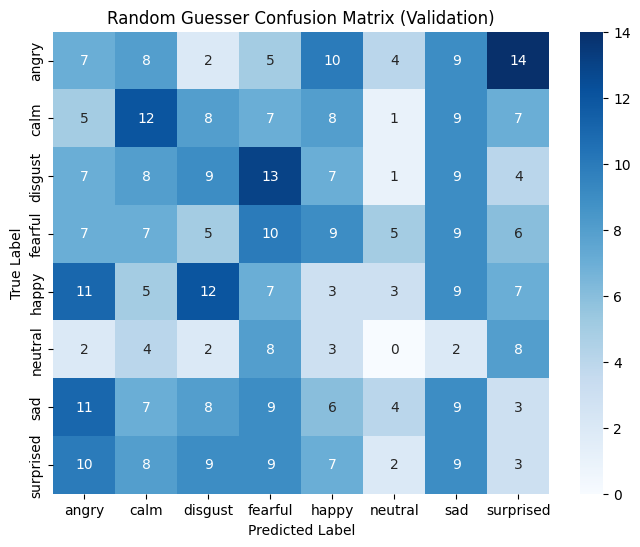

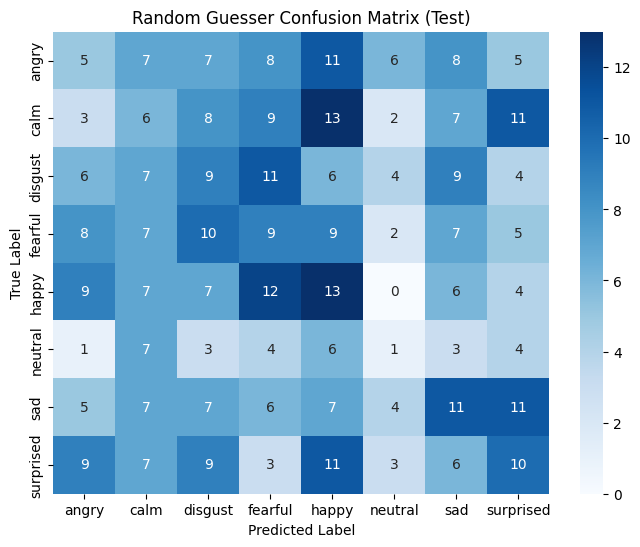

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Below function is for random guesser, baseline 1
def random_guesser(X, y):
    # make random predictions, based on dataset distribution in training set
    unique_classes, class_distribution = np.unique(y_train, return_counts=True)
    class_probabilities = class_distribution / class_distribution.sum()
#Make the preds
    random_predictions = np.random.choice(unique_classes, size=len(y), p=class_probabilities)
    return random_predictions

#make preds for validation and test
y_val_random = random_guesser(X_val, y_val)
y_test_random = random_guesser(X_test, y_test)

# Calculate accuracy for validation and test sets, print out then
val_random_accuracy = accuracy_score(y_val, y_val_random)
test_random_accuracy = accuracy_score(y_test, y_test_random)
print(f"Random Guesser Validation Accuracy: {val_random_accuracy:.4f}")
print(f"Random Guesser Test Accuracy: {test_random_accuracy:.4f}")

# Classification report for validation and test sets, checkout various accuracy markers
print("\nRandom Guesser Classification Report (Validation):")
print(classification_report(y_val, y_val_random, target_names=label_encoder.classes_))
print("\nRandom Guesser Classification Report (Test):")
print(classification_report(y_test, y_test_random, target_names=label_encoder.classes_))

# Confusion matrix for validation and test sets, checkout which emotions have main misallocations
cm_val_random = confusion_matrix(y_val, y_val_random)
cm_test_random = confusion_matrix(y_test, y_test_random)

#Below function is to plot confusion matrices
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

#Call the func for conf matrices
plot_confusion_matrix(cm_val_random, title="Random Guesser Confusion Matrix (Validation)")
plot_confusion_matrix(cm_test_random, title="Random Guesser Confusion Matrix (Test)")


Basic baseline number 2: Simple linear regression with flattened MFCC's

Validation Accuracy: 0.8657
Test Accuracy: 0.8565

Classification Report (Validation):
              precision    recall  f1-score   support

       angry       0.94      0.86      0.90        59
        calm       0.85      0.93      0.89        57
     disgust       0.83      0.86      0.85        58
     fearful       0.92      0.78      0.84        58
       happy       0.86      0.84      0.85        57
     neutral       0.92      0.83      0.87        29
         sad       0.85      0.89      0.87        57
   surprised       0.80      0.91      0.85        57

    accuracy                           0.87       432
   macro avg       0.87      0.86      0.87       432
weighted avg       0.87      0.87      0.87       432


Classification Report (Test):
              precision    recall  f1-score   support

       angry       0.94      0.89      0.92        57
        calm       0.83      0.90      0.86        59
     disgust       0.79      0.82      0.81        56
     fearful  

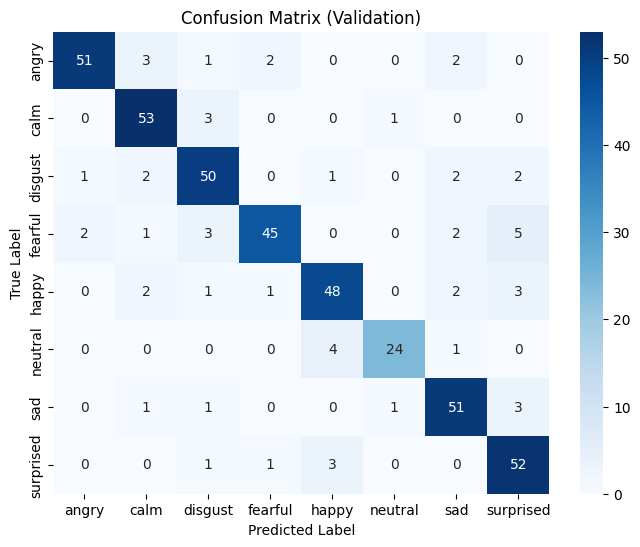

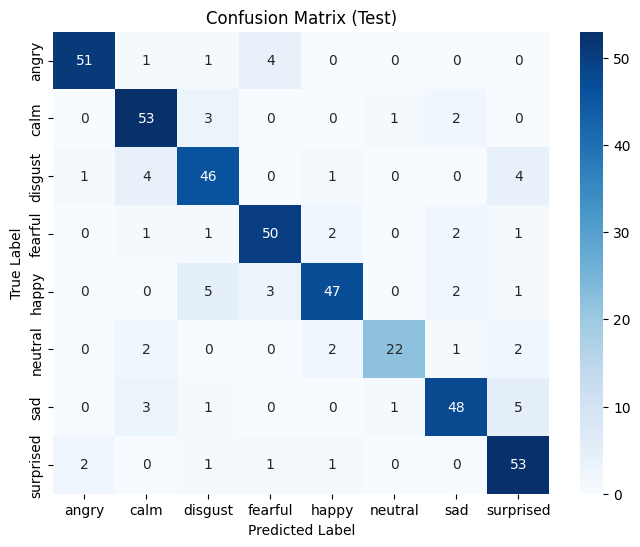

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

#Have to flatten mfcc input, so log reg can intake the info
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

#Below code scales the data to have zero mean and unit variance using StandardScaler
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_val_flat_scaled = scaler.transform(X_val_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)

#make and start training, LR, 1000 max iters
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_flat_scaled, y_train)

#Need to eval model on validation set
y_val_pred = logistic_model.predict(X_val_flat_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

#Then eval on test set
y_test_pred = logistic_model.predict(X_test_flat_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

#Classification reports for val and test
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

#Confusion matrices for val and test
cm_val = confusion_matrix(y_val, y_val_pred)
print("\nConfusion Matrix (Validation):")
print(cm_val)
cm_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test):")
print(cm_test)

#Function to plot confusino matrices
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
plot_confusion_matrix(cm_val, title="Confusion Matrix (Validation)")
plot_confusion_matrix(cm_test, title="Confusion Matrix (Test)")


BELOW IS THEBEGINNING OF THE TESTING AND EVALUATION SECTION:










------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

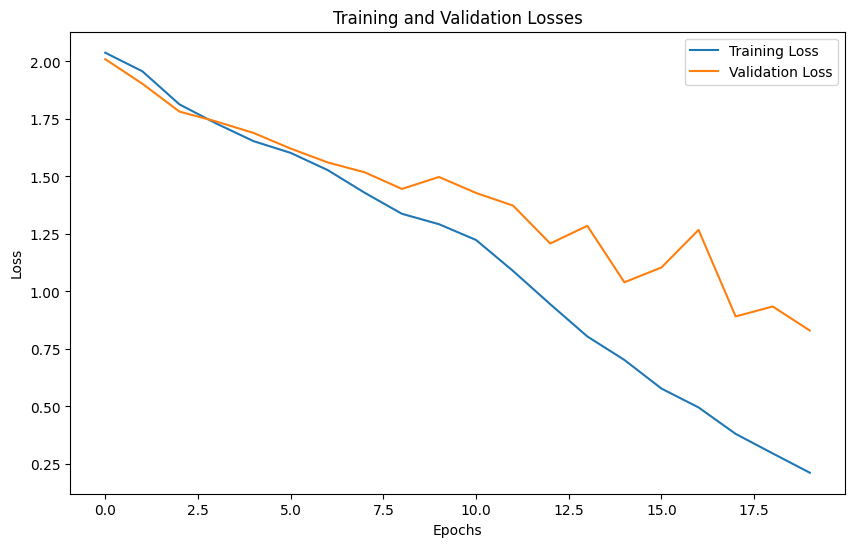

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Model 1

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
import sys
#Below, setting up files to log training and validation output to , per model number
log_file = open("model1.txt", "w")
sys.stdout = log_file
#Below is a class for our CRNN implementation, with various functions for setup, forward pass, training, evaluation, plotting and so on
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        #Setting up convolutional and pool layers for our later implementation in the forward pass
        #Params: (input channels, output channels/feature maps, dimensions of the conv filter, amount of padding for border)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d((2, 2))
        #Setting up RNN implementation (LSTM), input sized according to output of conv layers, specifies hidden state size and number of LSTM layers to add
        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)
        #Feed forward fully connected layer, to translate output of previous layers into size of "num_classes", producing output probabilities for different classes
        self.fc = nn.Linear(256, num_classes)
    #Foward pass method to propagate data through the network
    def forward(self, x):
        #Below are the convolutional layers, then a RELU activation function, followed by pooling layers (CNN part of CRNN implementation)
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        #Rearrange dimensions of CNN output so that it can be fed into the LSTM in correct
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        #Below we are calling the LSTM on x and obtaining the output
        x, _ = self.lstm(x)
        #Calling fully conn feed foward layer on output of LSTM layer, returns "num classes" outputs, returning raw logits for loss calculation
        x = self.fc(x[:, -1, :])
        return x

#Below code is to prepare the data to be used in the model, and to create the datasets and dataloaders
def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    #Convert y to tensor with long datatype
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

#Create the datasets and dataloaders for training and validation sets
train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
#Loads training and val data, shuffles for training to avoid pattern learning
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#Below function trains the model, using the training and validation loaders, and a specified number of epochs
def train_model(model, train_loader, val_loader, num_epochs=20):
    #Setting criterion is cross entropy loss
    criterion = nn.CrossEntropyLoss()
    #Setting up optimiser with learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #instantiating arrays to colelct loss data
    train_losses, val_losses = [], []
    #Iterating over epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        #Below is the training loop, where we iterate over the training loader, and perform forward pass, loss calculation, backpropagation, and optimization
        for inputs, labels in train_loader:
            #Zero the gradients to prevent accumulation of gradients from previous iterations
            optimizer.zero_grad()
            #Perform forward pass to get outputs
            outputs = model(inputs)
            #Calculate loss using the outputs and labels
            loss = criterion(outputs, labels)
            #Backpropagation to calculate gradients
            loss.backward()
            #Optimization step to update model parameters
            optimizer.step()
            #Add loss to running loss to keep track of total loss for the epoch
            running_loss += loss.item()
        #Append the average loss for the epoch to the training losses list
        train_losses.append(running_loss / len(train_loader))

        # Validation loop to evaluate the model on the validation set
        model.eval()
        #Initialize validation loss, correct predictions, and total predictions to 0
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        #Disable gradient calculation for validation to save memory and computation
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy by comparing predicted labels to true labels
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        #Append the average validation loss to the validation losses list
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds
        #Print the training and validation loss, and validation accuracy for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

#Below function sets the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    #Set seed for torch, cuda, and cudnn to ensure reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #Deterministic behavior for cudnn
    torch.backends.cudnn.deterministic = True
    #Disable benchmarking to ensure reproducibility
    torch.backends.cudnn.benchmark = False
#Set Seed to 42 consistently
set_seed(42)
#Initialize and train the model, using my CRNN class, the number of classes, input shape, and the train and validation loaders
input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)

#Below function plots the training and validation losses for the model
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()
#Call the plot_losses function to plot the training and validation losses
plot_losses(train_losses, val_losses)
#Download the log file for the model
files.download('model1.txt')

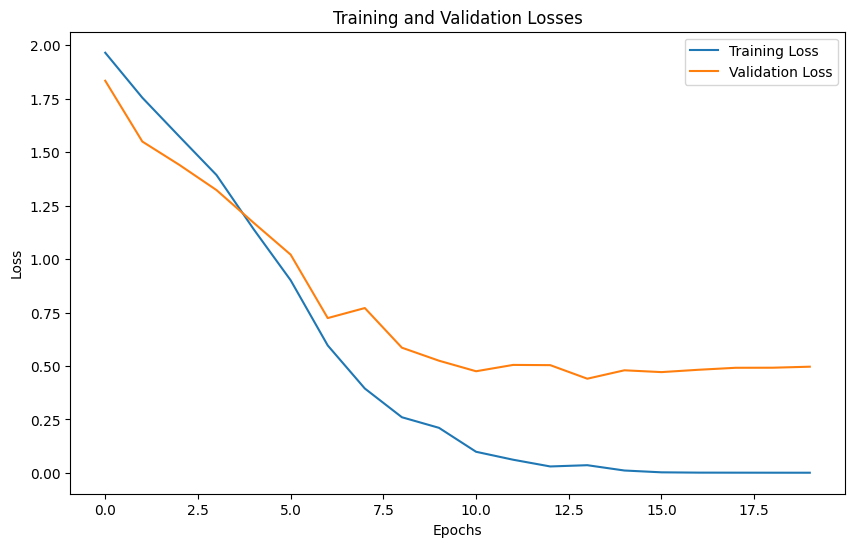

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 2
#Added batch normalisation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model2.txt", "w")
sys.stdout = log_file

class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        #Setting up batch norm based on output size of conv
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        #Setting up batch norm based on output size of conv
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))

        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        #Batch norm added below
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        #Batch norm added below
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model2.txt')


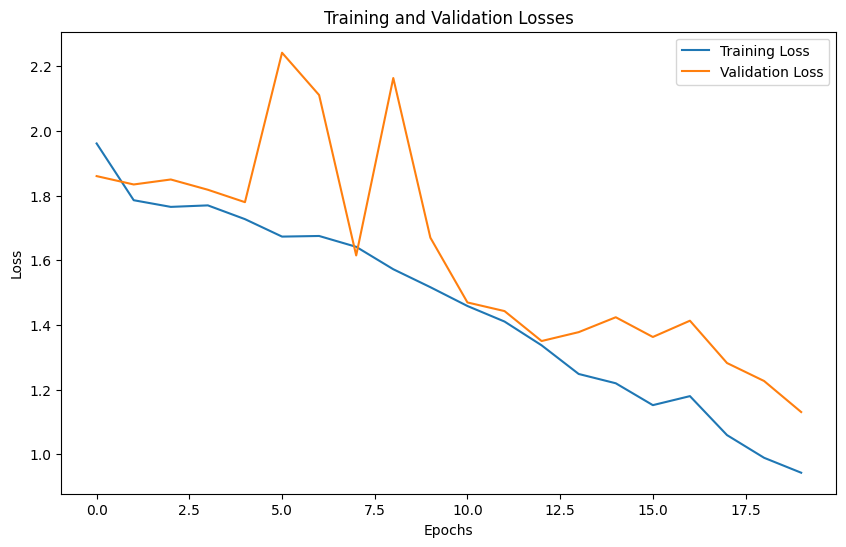

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 3
#added pool, conv, and ffnn layer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model3.txt", "w")
sys.stdout = log_file

class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        #Additional conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        #Subsequent additional batch norm
        self.bn3 = nn.BatchNorm2d(128)
        #additional pooling
        self.pool = nn.MaxPool2d((2, 2))
        self.lstm = nn.LSTM(input_size=128 * (input_shape[-1] // 8), hidden_size=256, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(256, 128)
        #ADditional feedfoward
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        x, _ = self.lstm(x)
        x = self.fc1(x[:, -1, :])
        x = torch.relu(x)
        x = self.fc2(x)
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model3.txt')


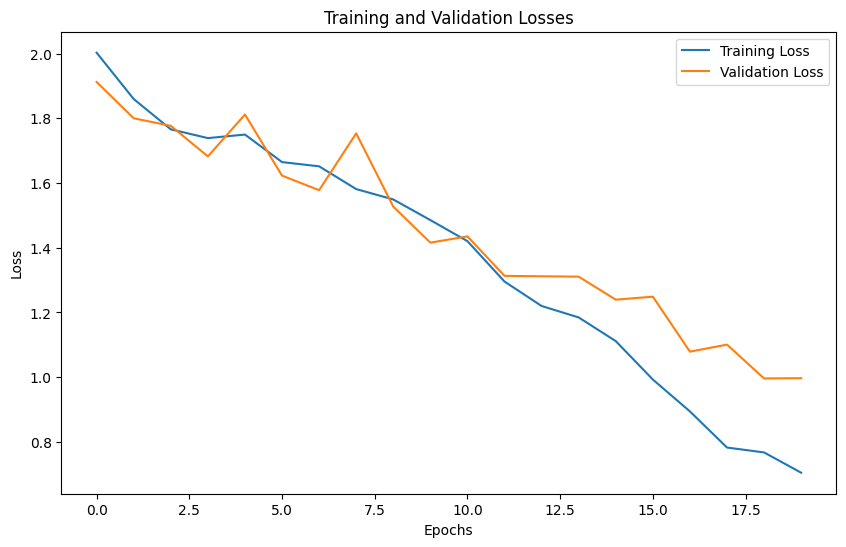

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#Model 4,
# added two LSTM layers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model4.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))

        #Instantiate with additional LSTM layers "num_layers=4"
        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=4, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))


        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model4.txt')

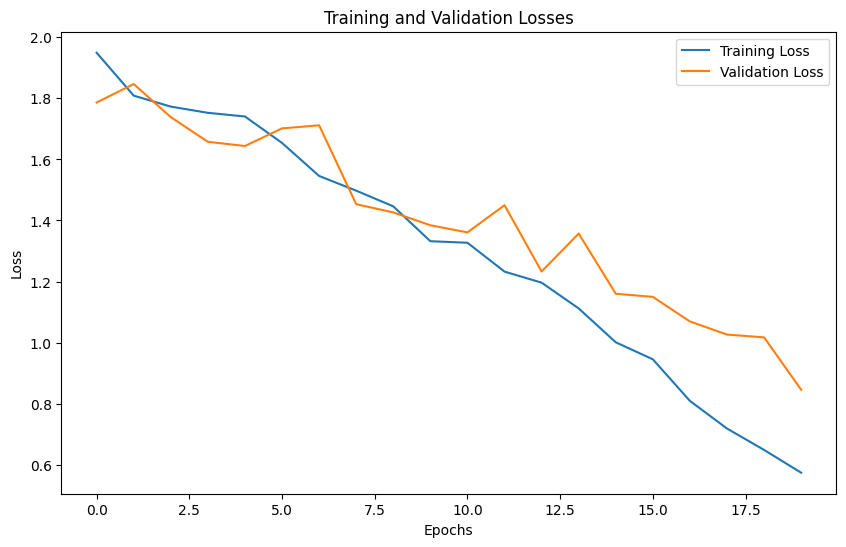

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 5
#Just added additional conv and pool

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model5.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        #additional conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        #additional batch norm
        self.bn3 = nn.BatchNorm2d(128)
        #additional pool
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=128 * (input_shape[-1] // 8), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool(x)


        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)


        x = self.fc(x[:, -1, :])
        return x


def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)


train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model5.txt')

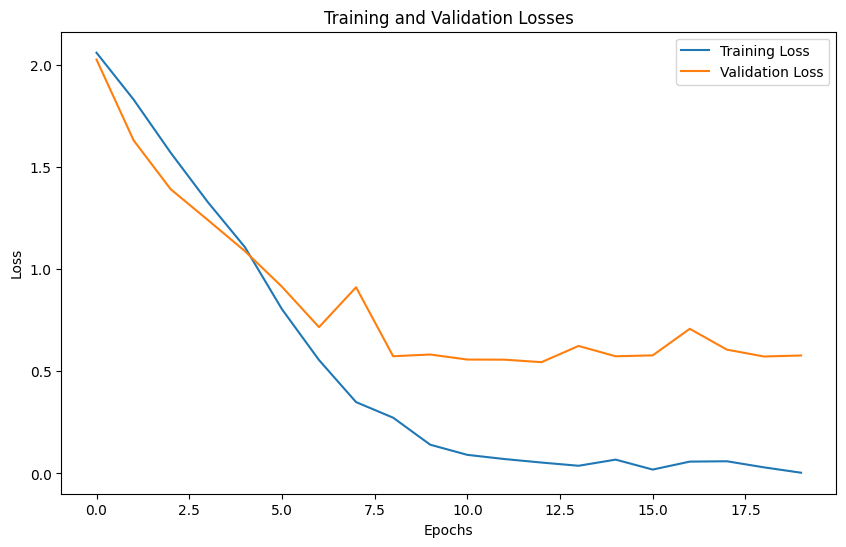

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#model 6
#LSTM hidden state size 512

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model6.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        #Instantiate with hidden state size 512, "hidden_size=512"
        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=512, num_layers=2, batch_first=True)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)


train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model6.txt')

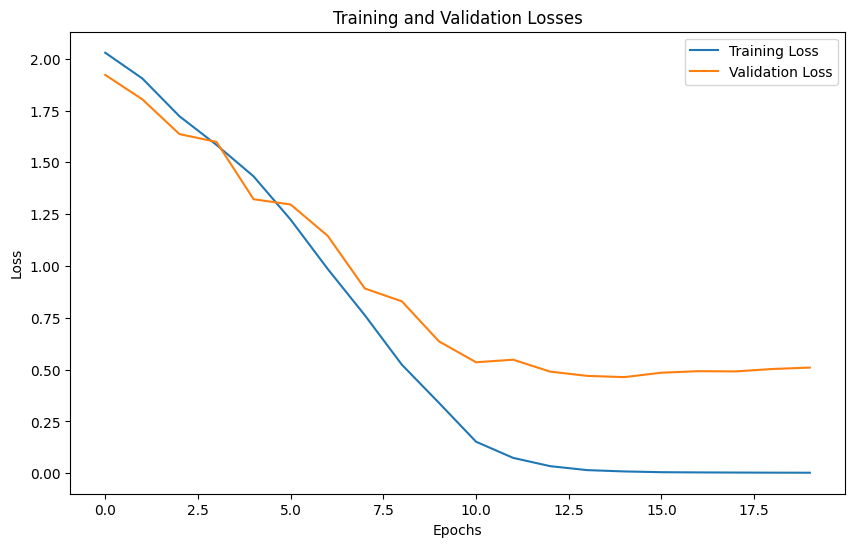

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 7
#LSTM hidden state size 128

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model7.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        #Instantiate with hidden state size 128, "hidden_size=128"
        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=128, num_layers=2, batch_first=True)

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

files.download('model7.txt')


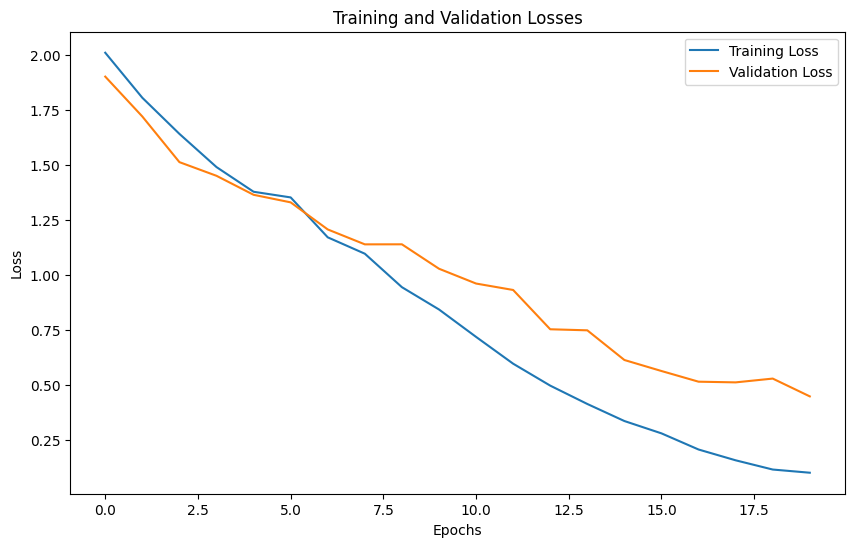

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 8
#learning rate 0.0001
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model8.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    #Make optimiser with new learning rate 0.0001
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model8.txt')

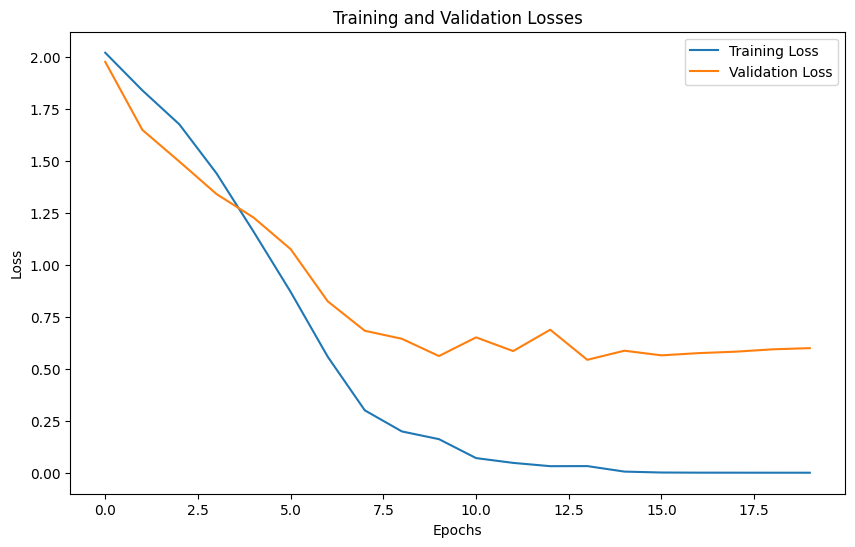

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 9
#learning rate 0.002
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model9.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    #new learning rate 0.002
    optimizer = optim.Adam(model.parameters(), lr=0.002)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model9.txt')


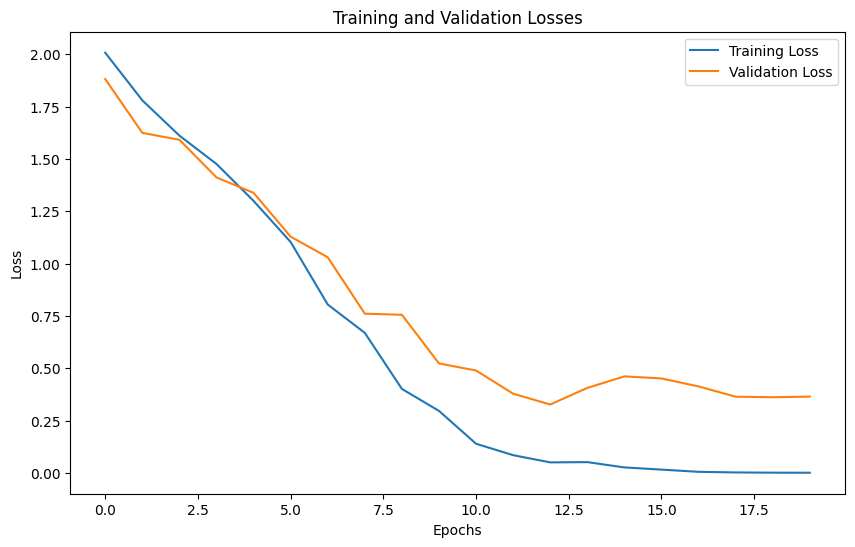

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


#model 10
#changing batch size to 64
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model10.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)


train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
#Batch size = 64
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)


files.download('model10.txt')

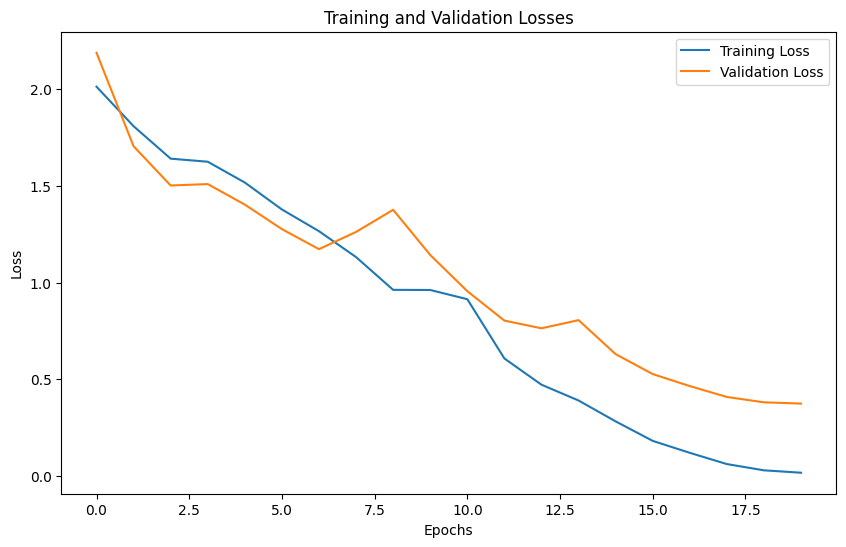

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#model 10
#changing batch size to 128
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model11.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
#Batch size set to 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

files.download('model11.txt')


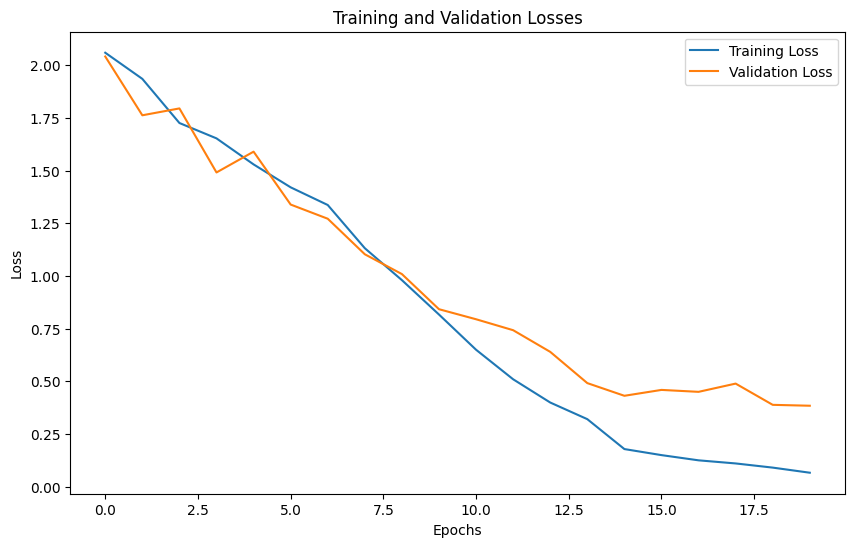

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


#Model 12
#adding 0.2 dropout

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model12.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        #adding 0.2 dropout
        self.dropout = nn.Dropout(0.2)

        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        #adding 0.2 dropout
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        #adding 0.2 dropout
        x = self.dropout(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

files.download('model12.txt')


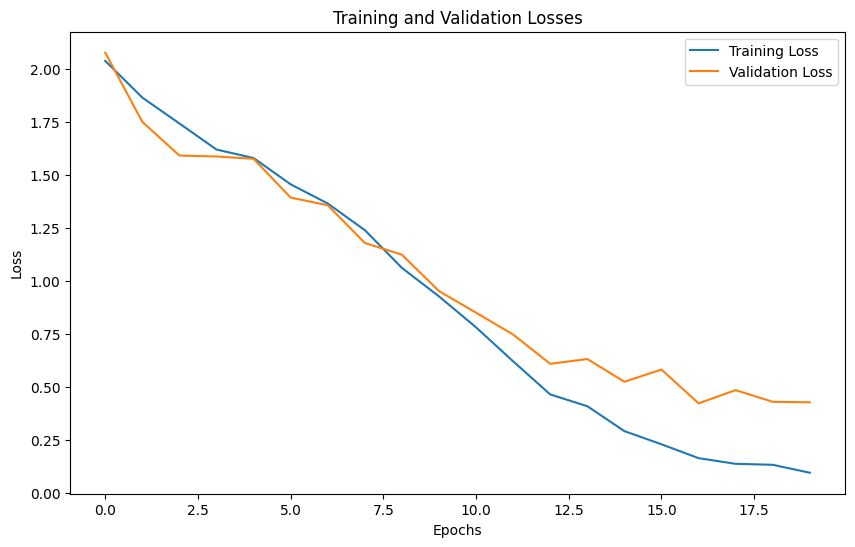

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#model 13
#adding 0.1 dropout
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model13.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))
        #adding 0.1 dropout
        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        #adding 0.1 dropout
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)
        #adding 0.1 dropout
        x = self.dropout(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

files.download('model13.txt')


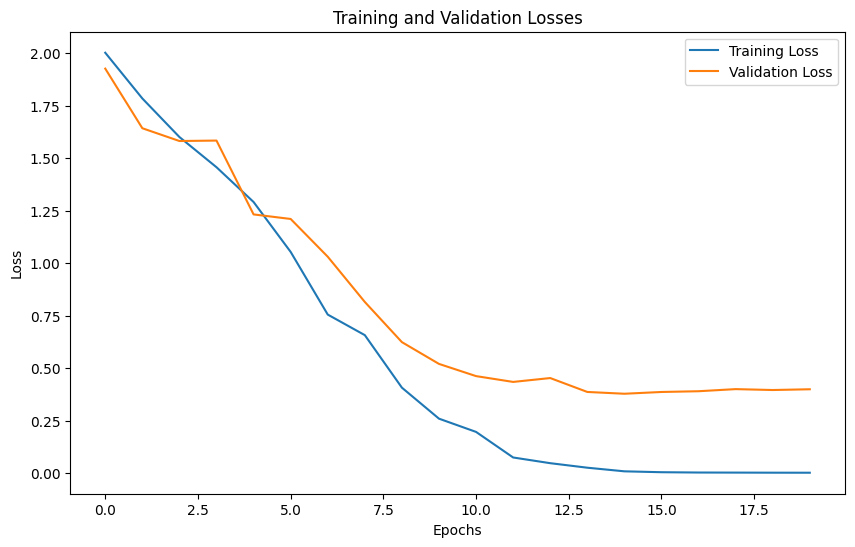

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#Model 14
#adding weight decay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model14.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    #instantiate optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model14.txt')



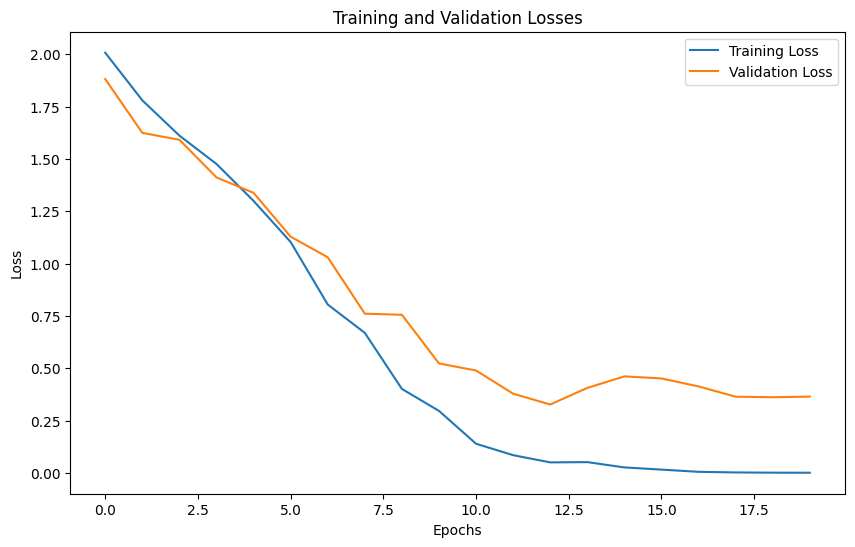

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

#model 15
#Added early stopping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("model15.txt", "w")
sys.stdout = log_file

class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

#below class is for early stopping in the model training
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        # Initialize the early stopping class with the given patience and minimum delta values
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
    # Function to check if early stopping should be triggered based on the validation loss
    def step(self, val_loss):
      # If the best loss has not been set, set it to the current validation loss
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        # If the validation loss is less than the best loss by the minimum delta, reset the counter and update the best loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        # Otherwise, increment the counter and check if it exceeds the patience
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

def train_model(model, train_loader, val_loader, num_epochs=20, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #Instantiate early stopping class
    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        # Check if early stopping should be triggered based on the validation loss and break the loop
        if early_stopping.step(val_losses[-1]):
            print("Early stopping triggered!")
            break

    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20, patience=5)



def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('model15.txt')

Below is final evaluation on test set using best model chosen

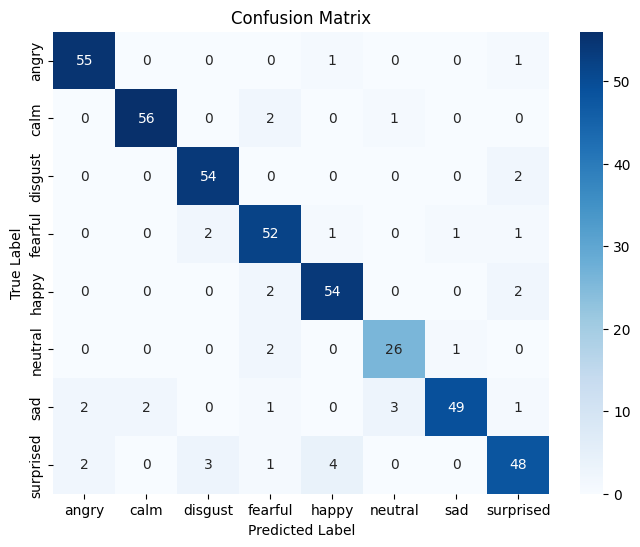

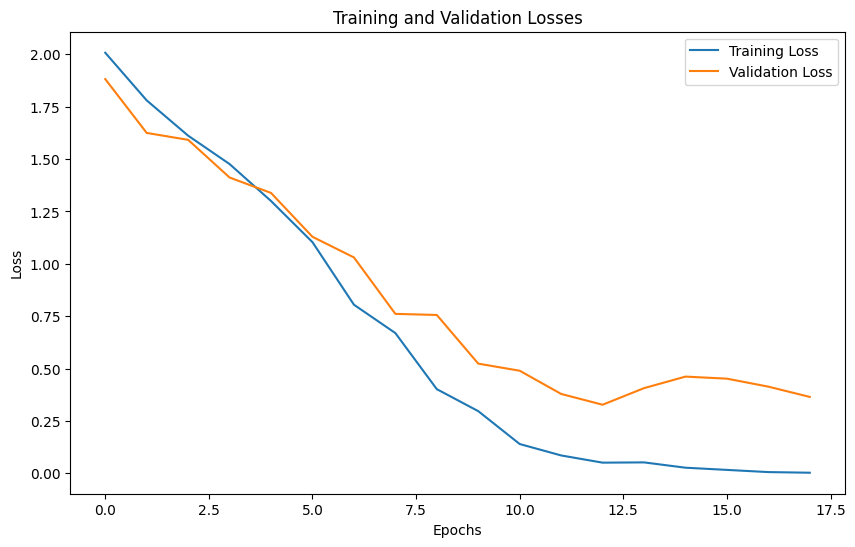

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
log_file = open("Final_test.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
#Also now bring in testing set
test_dataset = prepare_data(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
#Prepare the test loader
test_loader = DataLoader(test_dataset, batch_size=64)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

def train_model(model, train_loader, val_loader, num_epochs=20, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if early_stopping.step(val_losses[-1]):
            print("Early stopping triggered!")
            break

    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20, patience=5)
#Function to evaluate the model on the test set and print the classification report and confusion matrix
def evaluate_model(model, test_loader, y_test):
    model.eval()
    y_test_pred = []
    y_true = []
# Iterate over the test set and make predictions with the trained model
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # Append the predictions and true labels to the lists
            y_test_pred.extend(predicted.cpu().numpy())
            # Convert the labels to numpy array and extend the list
            y_true.extend(labels.cpu().numpy())
    #printing out ald calculating test acc
    test_accuracy = accuracy_score(y_true, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
#printing class reports
    print("\nClassification Report:")
    print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))
#Confusion matrix
    cm = confusion_matrix(y_true, y_test_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plot_confusion_matrix(cm)
#Functon to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
#Calling evaluation function
evaluate_model(model, test_loader, y_test)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('Final_test.txt')

Below is the final evaluation again, but just with some additional code to save the models predictions on the test set toa file.

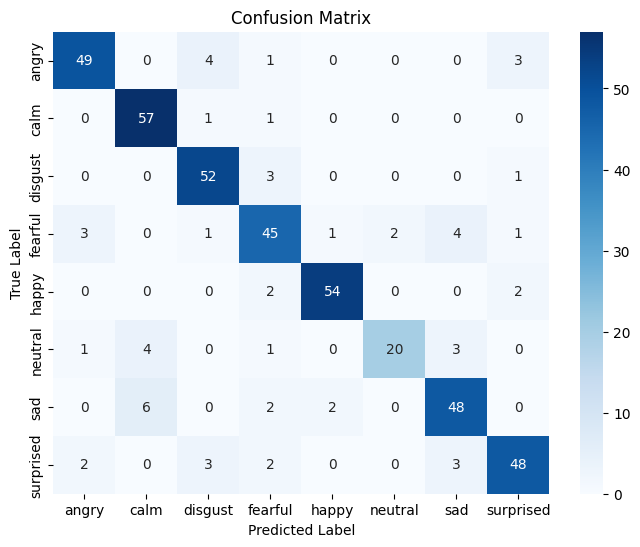

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

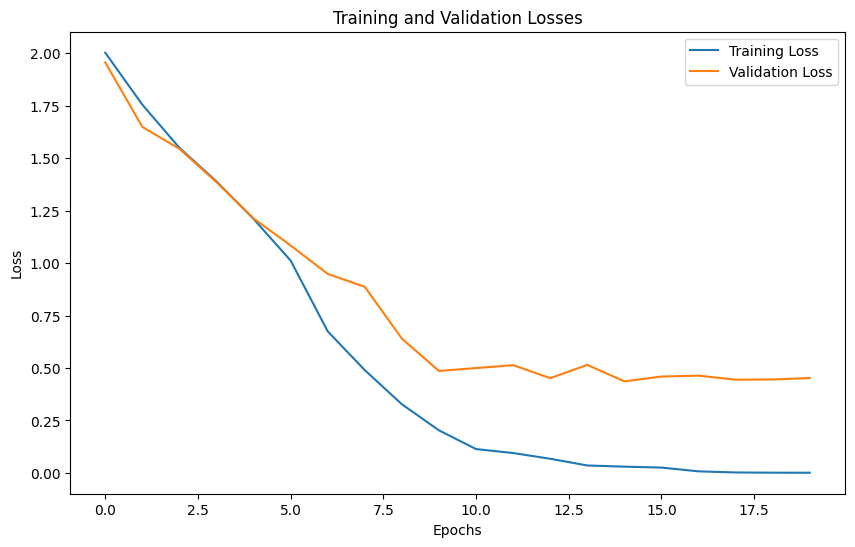

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from google.colab import files
import sys
log_file = open("Final_test.txt", "w")
sys.stdout = log_file
class CRNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 2))


        self.lstm = nn.LSTM(input_size=64 * (input_shape[-1] // 4), hidden_size=256, num_layers=2, batch_first=True)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)

        x, _ = self.lstm(x)

        x = self.fc(x[:, -1, :])
        return x

def prepare_data(X, y):
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    print(f"After unsqueezing, X shape: {X.shape}")
    y = torch.tensor(y, dtype=torch.long)
    return TensorDataset(X, y)

train_dataset = prepare_data(X_train, y_train)
val_dataset = prepare_data(X_val, y_val)
#Also now bring in testing set
test_dataset = prepare_data(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
#Prepare the test loader
test_loader = DataLoader(test_dataset, batch_size=64)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

def train_model(model, train_loader, val_loader, num_epochs=20, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_preds / total_preds

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if early_stopping.step(val_losses[-1]):
            print("Early stopping triggered!")
            break

    return train_losses, val_losses

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

input_shape = X_train.shape[1:]
num_classes = len(label_encoder.classes_)
model = CRNN(num_classes, input_shape)
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20, patience=5)
# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved as 'trained_model.pth'.")



#Function to evaluate the model on the test set and print the classification report and confusion matrix
def evaluate_model(model, test_loader, y_test):
    model.eval()
    y_test_pred = []
    y_true = []
# Iterate over the test set and make predictions with the trained model
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # Append the predictions and true labels to the lists
            y_test_pred.extend(predicted.cpu().numpy())
            # Convert the labels to numpy array and extend the list
            y_true.extend(labels.cpu().numpy())
    #printing out ald calculating test acc
    test_accuracy = accuracy_score(y_true, y_test_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
#printing class reports
    print("\nClassification Report:")
    print(classification_report(y_true, y_test_pred, target_names=label_encoder.classes_))
#Confusion matrix
    cm = confusion_matrix(y_true, y_test_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plot_confusion_matrix(cm)

    #Below is saving the output on the test set.
    results_df = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_test_pred
    })
    results_df.to_csv('test_predictions.csv', index=False)
    print("Test predictions saved to 'test_predictions.csv'.")


#Functon to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()
#Calling evaluation function
evaluate_model(model, test_loader, y_test)




files.download('test_predictions.csv')

files.download('trained_model.pth')


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)
files.download('Final_test.txt')